In [1]:
from datetime import datetime
import numpy as np
import math
import copy
import os
import random
from initialization import make_world, get_tasks, initial_env, initial_agents, initial_work_region, initial_specification
from visualization import draw_path, draw_map, animate_solution
from heavy_WTS import total_states
from heavy_path_generation import heavy_path, get_work_map, get_path_cell2coord, get_independent_requests_tasks
from request_exchange import collect_deliver, complete_path


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    UNDERLINE = '\033[4m'

In [2]:
# dirname = os.path.dirname
# ABPATH = os.path.join(dirname(dirname(__file__)))

ABPATH = os.path.dirname(os.getcwd())

"""create the folder for the fig, file, output(video)"""
now = datetime.today().strftime('%Y-%m-%d')
fig_folder = ABPATH + '/figures/' + str(now)
file_folder = ABPATH + '/files/' + str(now)
output_folder = ABPATH + '/files/' + str(now) + '/output'
if not (os.path.exists(fig_folder)):
    os.makedirs(fig_folder)
if not (os.path.exists(file_folder)):
    os.makedirs(file_folder)
if not (os.path.exists(output_folder)):
    os.makedirs(output_folder)

Init heavy_duty agents:  [[5, 10], [6, 12], [26, 20], [23, 0]] . Init light_duty agent:  [6, 4]
MITL Specification of R 1 :  [['E', '27', '36', 'w98'], ['E', '45', '50', 'w87']]
MITL Specification of R 2 :  [['E', '30', '40', 'w52', 'R2', 'meet'], ['G', '62', '69', 'w48'], ['E', '70', '78', 'w54', 'R3', 'col']]
MITL Specification of R 3 :  [['E', '8', '12', 'w49'], ['E', '43', '47', 'w54', 'R3', 'meet'], ['G', '72', '75', 'w39']]
MITL Specification of R 4 :  [['G', '11', '15', 'w12'], ['G', '37', '42', 'w20', 'R1', 'meet']]


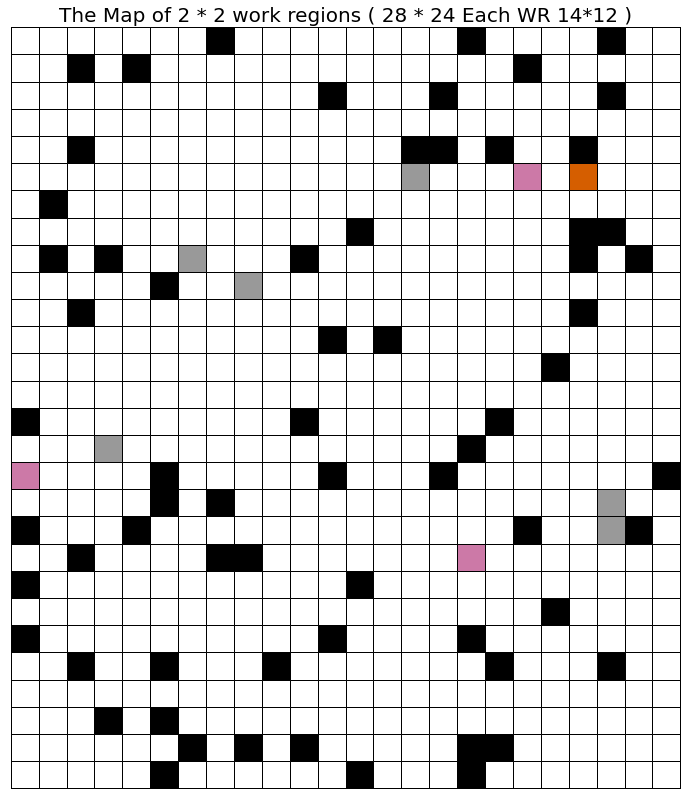

In [4]:
"""
Initial the environment
Get the number robots: num_agent_heavy, num_agent_light
Get the size of the work region: region_row, region_col
Get the whole map with obstacles: 2*(N/2) work regions, obs_percentage, obs_list
Get the map and state space of the env: map_original, map_obstacle, states_original
Get the map and state space of work regions for each heavy-duty robot: work_region, map_work_region, states_work_region
Get initial position of all robots: agents_heavy, agents_light
"""
num_agent_heavy = random.choice([2,4,6])
num_agent_light = 1
region_row, region_col = [random.randint(10, 15), random.randint(10, 15)]
map_row, map_col = [region_row * 2, int(region_col * (num_agent_heavy / 2))]
obs_percentage = 10
obs_list = initial_env(region_row * 2, region_col * (num_agent_heavy / 2), obs_percentage)
map_original = np.zeros((map_row, map_col), dtype=int)
map_obstacle = copy.deepcopy(map_original)
for i in range(len(obs_list)):
    map_obstacle[obs_list[i][0]][obs_list[i][1]] = 1
states_original = total_states(map_obstacle)
work_region = initial_work_region(num_agent_heavy, region_row, region_col)
map_work_region = [get_work_map(map_obstacle, work_region, i) for i in range(num_agent_heavy)]
states_work_region = [total_states(map_work_region[i]) for i in range(num_agent_heavy)]

agents_heavy, [agents_light] = initial_agents(work_region, obs_list, num_agent_heavy, num_agent_light)
print("Init heavy_duty agents: ", agents_heavy, ". Init light_duty agent: ", agents_light)

# get the MITL task specification
specifications = initial_specification(obs_list, agents_heavy, agents_light, work_region, states_work_region)
for i in range(num_agent_heavy):
    print("MITL Specification of R", i+1, ": ", specifications[i])

task_type = get_tasks(specifications, states_work_region)
map_obs_work = copy.deepcopy(map_obstacle)
draw_map(map_obs_work, task_type, num_agent_heavy, fig_folder)


In [5]:
"""
--------------- light-duty robot module ---------------
"""
# initial the parameters of agents
u_size = 1
r_i = 1
r_0 = 2
# hatch distance
h_a = 2 * r_0 - 1
# velocity / transition weight constraints
v_heavy = 1
v_light = max([math.ceil(
    ((2 * (work_region[i][3] - work_region[i][2] - 2 * r_0 - u_size) + h_a) *
     v_heavy) / ((2 * r_0) - (h_a - u_size))) for i in range(num_agent_heavy)])


In [6]:
"""
--------------- Pre-computation ---------------
"""
path_existence = [[] for i in range(num_agent_heavy)]
initial_path = [[] for i in range(num_agent_heavy)]
independent_path = [[] for i in range(num_agent_heavy)]
independent_task = [[] for i in range(num_agent_heavy)]
independent_request = []
independent_path_2d = [[] for i in range(num_agent_heavy)]

for i in range(num_agent_heavy):
    flag = "R" + str(i)
    # check if the initial specifications are satisfied
    initial_path[i] = heavy_path(map_work_region[i], specifications[i], file_folder, flag,
                                 agents_heavy[i]).get_path()
    # check if robot need to cooperate and provide best promise.  (bool) coop, promise
    if len(initial_path[i]) == 0:
        path_existence[i] = False
        print(path_existence[i])
        print("========There is no path satisfying the specification!========")
    else:
        path_existence[i] = True
if all(item is True for item in path_existence):
    for i in range(num_agent_heavy):
        independent_task, independent_request = get_independent_requests_tasks(specifications, map_work_region,
                                                                               agents_heavy, file_folder)
        independent_path[i] = heavy_path(map_work_region[i], independent_task[i], file_folder, flag,
                                         agents_heavy[i]).get_path()
        independent_path_2d[i] = get_path_cell2coord(independent_path[i], states_work_region[i])


The initial position is  w61
The initial position is  w61
Buildfile: /home/wei/uppaal64-4.1.26/demo/ModelDemo/build.xml

-pre-init:

-init-private:

-init-user:

-init-project:

-init-macrodef-property:

-init-modules-supported:

-do-init:

-post-init:

-init-check:

-init-ap-cmdline-properties:

-init-macrodef-modulename:

-init-source-module-properties:

-init-macrodef-javac-with-module:

-init-macrodef-javac-with-processors:

-init-macrodef-javac-without-processors:

-init-macrodef-javac:

-init-macrodef-test-impl:

-init-macrodef-junit-init:

-init-test-properties:

-init-macrodef-junit-prototype-with-module:

-init-macrodef-junit-prototype-without-module:

-init-macrodef-junit-single:

-init-macrodef-junit-batch:

-init-macrodef-junit:

-init-macrodef-junit-impl:

-init-macrodef-testng:

-init-macrodef-testng-impl:

-init-macrodef-test:

-init-macrodef-junit-debug-impl:

-init-macrodef-test-debug-junit:

-init-macrodef-testng-debug:

-init-macrodef-testng-debug-impl:

-init-macrod

In [7]:
print(f"{bcolors.HEADER}======== ***** The Pre-computation Result ****** ========")
print(f"{bcolors.HEADER}------- The Original Task Specification -------")
print(specifications)
print(f"{bcolors.HEADER}------------ If all the paths exist ------------")
print(path_existence)
if all(item is True for item in path_existence):
    print(f"{bcolors.HEADER}---- The Independent Task Specification ----")
    print(independent_task)
    print(f"{bcolors.HEADER}--------- The Independent Request ---------")
    print(independent_request)


======== ***** The Pre-computation Result ****** ========
------- The Original Task Specification -------
[[['E', '27', '36', 'w98'], ['E', '45', '50', 'w87']], [['E', '30', '40', 'w52', 'R2', 'meet'], ['G', '62', '69', 'w48'], ['E', '70', '78', 'w54', 'R3', 'col']], [['E', '8', '12', 'w49'], ['E', '43', '47', 'w54', 'R3', 'meet'], ['G', '72', '75', 'w39']], [['G', '11', '15', 'w12'], ['G', '37', '42', 'w20', 'R1', 'meet']]]
------------ If all the paths exist ------------
[True, True, True, True]
---- The Independent Task Specification ----
[[['E', '27', '36', 'w98'], ['E', '45', '50', 'w87']], [['G', '30', '40', 'w52', 'R2', 'meet'], ['G', '62', '69', 'w48']], [['E', '8', '12', 'w49'], ['G', '43', '47', 'w54', 'R3', 'meet'], ['G', '72', '75', 'w39']], [['G', '11', '15', 'w12'], ['G', '37', '42', 'w20']]]
--------- The Independent Request ---------
[[[], [], [], []], [[], [], [['E', '30', '40', 'w52', 'R2', 'meet']], [['E', '70', '78', 'w54', 'R3', 'col']]], [[], [], [], [['E', '43', 

In [8]:
 # make the world (core.py)
world = make_world(agents_heavy, agents_light, r_i, r_0, v_heavy, v_light, u_size, independent_task,
                   independent_request)


In [9]:
"""
Start two round SWEEP
"""
# start sweeping
# maximum 2 rounds to guarantee the requests exchange
from request_exchange import collect_deliver
num_round_exchange = 2

path_detect_round, independent_path_2d, record_working_region, record_task_left = \
    collect_deliver(world, map_obs_work, num_round_exchange, num_agent_heavy, work_region, states_work_region,
                    independent_path_2d, h_a, r_0, v_light, file_folder)


Round  0  Region 0
The closest start location is  [2 2]
Step  0 Robot 0 Pos [ 5 10] R0 pos:  [11  2]
Step  0 Robot 0 Pos [ 5 10] R0 pos:  [6 4]
Step  0 Robot 0 Pos [ 5 10] R0 pos:  [5 4]
Step  0 Robot 0 Pos [ 5 10] R0 pos:  [4 4]
Step  1 Robot 0 Pos [ 5 10] R0 pos:  [4 3]
Step  1 Robot 0 Pos [ 5 10] R0 pos:  [3 3]
Step  1 Robot 0 Pos [ 5 10] R0 pos:  [3 2]
Step  1 Robot 0 Pos [ 5 10] R0 pos:  [2 2]
Step  1 Robot 0 Task left:  ['w98', 'w87']
Step  1 Robot 1 Task left:  ['w52', 'w48']
Step  1 Robot 2 Task left:  ['w49', 'w54', 'w39']
Step  1 Robot 3 Task left:  ['w12', 'w20']
Step :  1 Light:  [2, 3] Heavy 0 :  [4, 10] Distance is:  9
Step  1 Robot 0 Pos [4, 10] R0 pos:  [2 3]
Step  1 Robot 0 Pos [4, 10] R0 pos:  [2 4]
Step  1 Robot 0 Pos [4, 10] R0 pos:  [2 5]
Step  2 Robot 0 Pos [4, 10] R0 pos:  [2 6]
Step  2 Robot 0 Pos [4, 10] R0 pos:  [2 7]
The heavy duty agent  0  is detected at step:  1 . Pos_heavy:  [4, 10] . Pos_light:  [2, 8] . Distance is:  4
Stop sweep at Region 1  at positio

java.io.IOException: Server connection lost
	at com.uppaal.engine.LexicalAnalyser.nextToken(LexicalAnalyser.java:223)
	at com.uppaal.engine.Parser.parseId(Parser.java:65)
	at com.uppaal.engine.DotProtocol.processQueryFeedback(DotProtocol.java:332)
	at com.uppaal.engine.DotProtocol.query(DotProtocol.java:181)
	at com.uppaal.engine.EngineStub.query(EngineStub.java:861)
	at com.uppaal.engine.Engine.query(Engine.java:476)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)
IOException: Server connection lost
	at com.uppaal.engine.Engine.query(Engine.java:480)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)


The initial position is  w239
Buildfile: /home/wei/uppaal64-4.1.26/demo/ModelDemo/build.xml

-pre-init:

-init-private:

-init-user:

-init-project:

-init-macrodef-property:

-init-modules-supported:

-do-init:

-post-init:

-init-check:

-init-ap-cmdline-properties:

-init-macrodef-modulename:

-init-source-module-properties:

-init-macrodef-javac-with-module:

-init-macrodef-javac-with-processors:

-init-macrodef-javac-without-processors:

-init-macrodef-javac:

-init-macrodef-test-impl:

-init-macrodef-junit-init:

-init-test-properties:

-init-macrodef-junit-prototype-with-module:

-init-macrodef-junit-prototype-without-module:

-init-macrodef-junit-single:

-init-macrodef-junit-batch:

-init-macrodef-junit:

-init-macrodef-junit-impl:

-init-macrodef-testng:

-init-macrodef-testng-impl:

-init-macrodef-test:

-init-macrodef-junit-debug-impl:

-init-macrodef-test-debug-junit:

-init-macrodef-testng-debug:

-init-macrodef-testng-debug-impl:

-init-macrodef-test-debug-testng:

-init

java.io.IOException: Server connection lost
	at com.uppaal.engine.LexicalAnalyser.nextToken(LexicalAnalyser.java:223)
	at com.uppaal.engine.Parser.parseId(Parser.java:65)
	at com.uppaal.engine.DotProtocol.processQueryFeedback(DotProtocol.java:332)
	at com.uppaal.engine.DotProtocol.query(DotProtocol.java:181)
	at com.uppaal.engine.EngineStub.query(EngineStub.java:861)
	at com.uppaal.engine.Engine.query(Engine.java:476)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)
IOException: Server connection lost
	at com.uppaal.engine.Engine.query(Engine.java:480)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)


The initial position is  w196
Buildfile: /home/wei/uppaal64-4.1.26/demo/ModelDemo/build.xml

-pre-init:

-init-private:

-init-user:

-init-project:

-init-macrodef-property:

-init-modules-supported:

-do-init:

-post-init:

-init-check:

-init-ap-cmdline-properties:

-init-macrodef-modulename:

-init-source-module-properties:

-init-macrodef-javac-with-module:

-init-macrodef-javac-with-processors:

-init-macrodef-javac-without-processors:

-init-macrodef-javac:

-init-macrodef-test-impl:

-init-macrodef-junit-init:

-init-test-properties:

-init-macrodef-junit-prototype-with-module:

-init-macrodef-junit-prototype-without-module:

-init-macrodef-junit-single:

-init-macrodef-junit-batch:

-init-macrodef-junit:

-init-macrodef-junit-impl:

-init-macrodef-testng:

-init-macrodef-testng-impl:

-init-macrodef-test:

-init-macrodef-junit-debug-impl:

-init-macrodef-test-debug-junit:

-init-macrodef-testng-debug:

-init-macrodef-testng-debug-impl:

-init-macrodef-test-debug-testng:

-init

java.io.IOException: Server connection lost
	at com.uppaal.engine.LexicalAnalyser.nextToken(LexicalAnalyser.java:223)
	at com.uppaal.engine.Parser.parseId(Parser.java:65)
	at com.uppaal.engine.DotProtocol.processQueryFeedback(DotProtocol.java:332)
	at com.uppaal.engine.DotProtocol.query(DotProtocol.java:181)
	at com.uppaal.engine.EngineStub.query(EngineStub.java:861)
	at com.uppaal.engine.Engine.query(Engine.java:476)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)
IOException: Server connection lost
	at com.uppaal.engine.Engine.query(Engine.java:480)
	at FooVeri.run(MITL_verification.java:844)
	at java.base/java.lang.Thread.run(Thread.java:833)


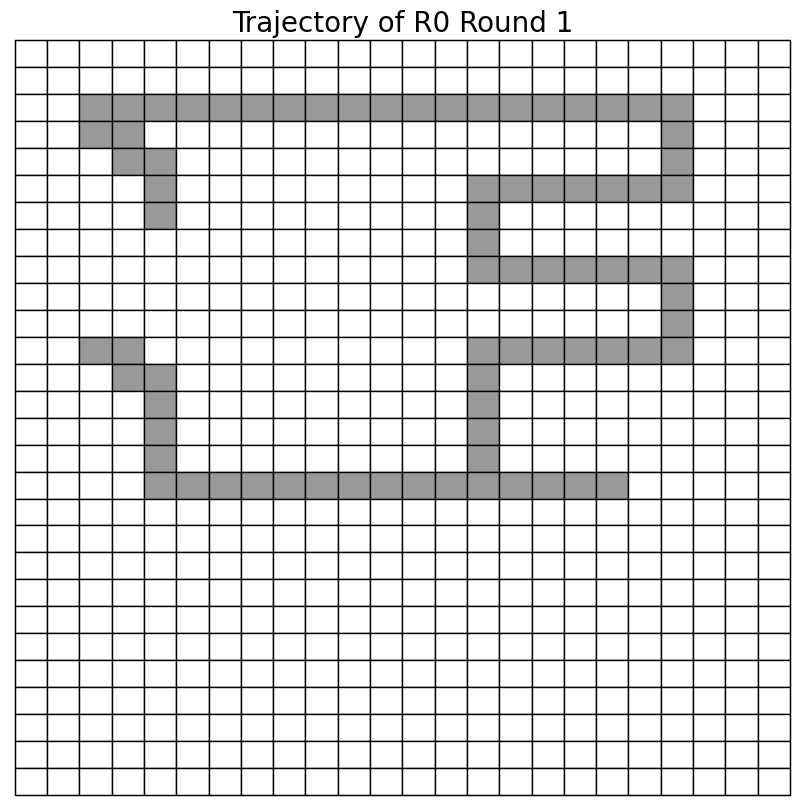

<Figure size 432x288 with 0 Axes>

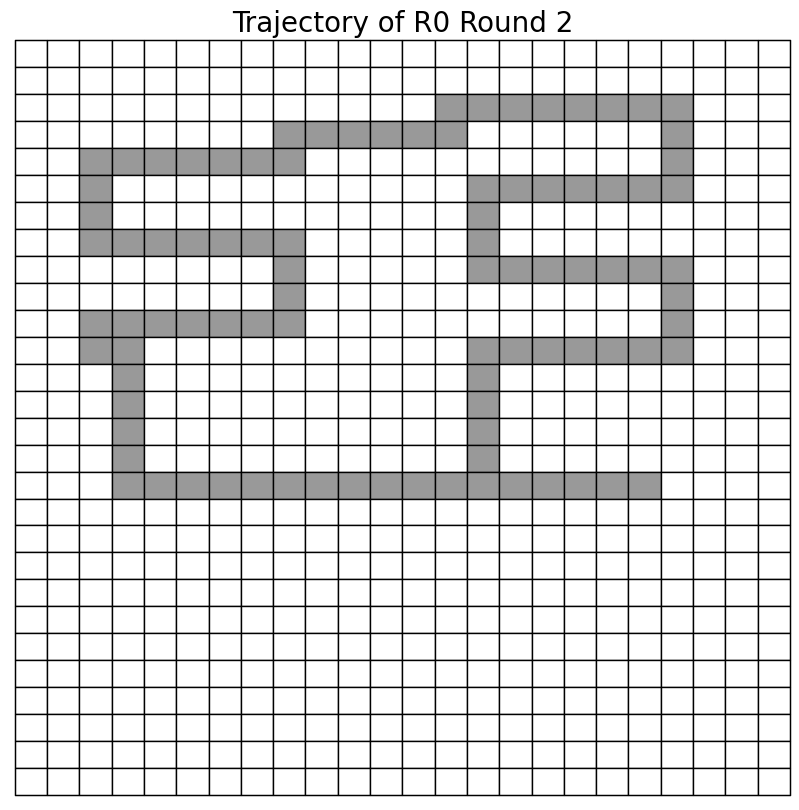

<Figure size 432x288 with 0 Axes>

In [10]:
"""
Path of agile light-duty robot
"""
path_detect_round[1] = path_detect_round[1][len(path_detect_round[0]): len(path_detect_round[1])]
for n in range(len(path_detect_round)):
    mm = copy.deepcopy(map_original)
    draw_path(mm, path_detect_round[n], fig_folder, "Trajectory of R0 Round " + str(n + 1))


Step  25 Robot 0 Task left:  ['w98', 'w87']
Step  25 Robot 1 Task left:  ['w62', 'w58', 'w208']
Step  25 Robot 2 Task left:  ['w246', 'w227', 'w52']
Step  25 Robot 3 Task left:  ['w218', 'w54', 'w54', 'w54', 'w54']
Step  25 Robot 0 Task left:  ['w98', 'w87']
Step  25 Robot 1 Task left:  ['w62', 'w58', 'w208']
Step  25 Robot 2 Task left:  ['w246', 'w227', 'w52']
Step  25 Robot 3 Task left:  ['w218', 'w54', 'w54', 'w54', 'w54']
Step  25 Robot 0 Task left:  ['w98', 'w87']
Step  25 Robot 1 Task left:  ['w62', 'w58', 'w208']
Step  25 Robot 2 Task left:  ['w246', 'w227', 'w52']
Step  25 Robot 3 Task left:  ['w218', 'w54', 'w54', 'w54', 'w54']
Step  26 Robot 0 Task left:  ['w98', 'w87']
Step  26 Robot 1 Task left:  ['w62', 'w58', 'w208']
Step  26 Robot 2 Task left:  ['w246', 'w227', 'w52']
Step  26 Robot 3 Task left:  ['w218', 'w54', 'w54', 'w54', 'w54']
Step  26 Robot 0 Task left:  ['w98', 'w87']
Step  26 Robot 1 Task left:  ['w62', 'w58', 'w208']
Step  26 Robot 2 Task left:  ['w246', 'w227'

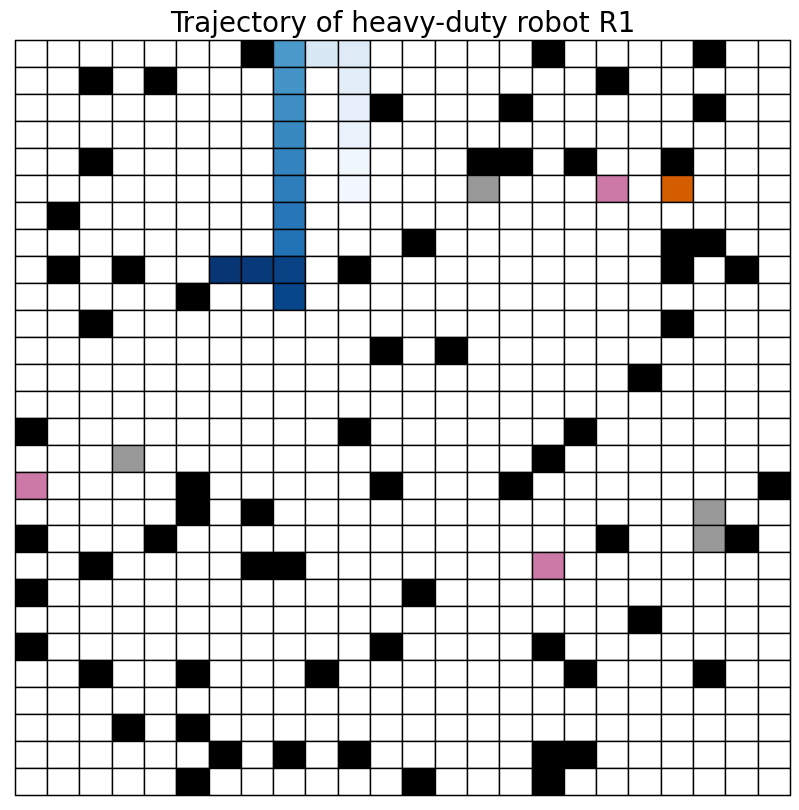

<Figure size 432x288 with 0 Axes>

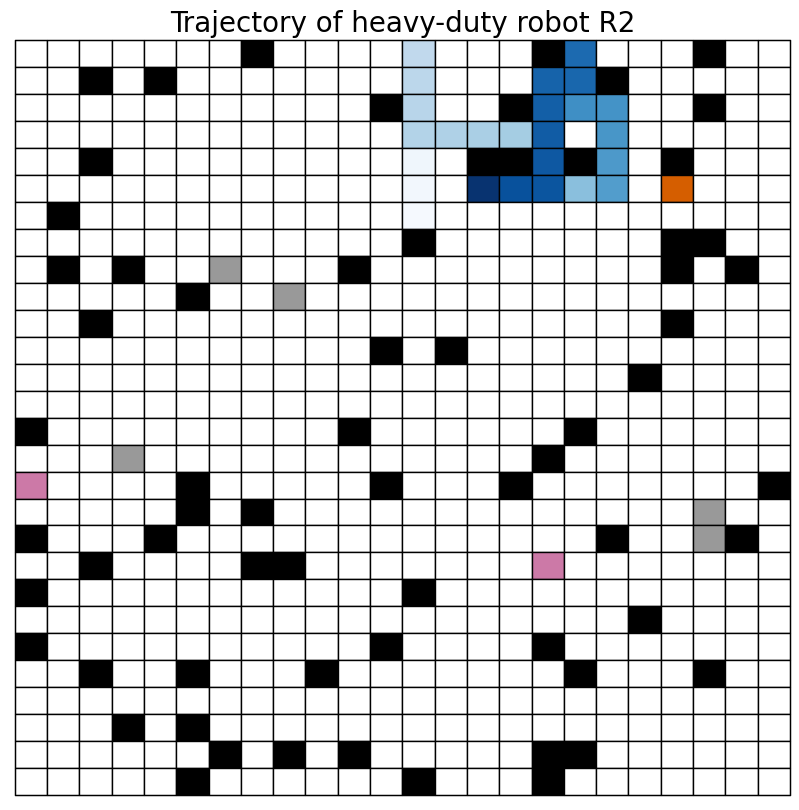

<Figure size 432x288 with 0 Axes>

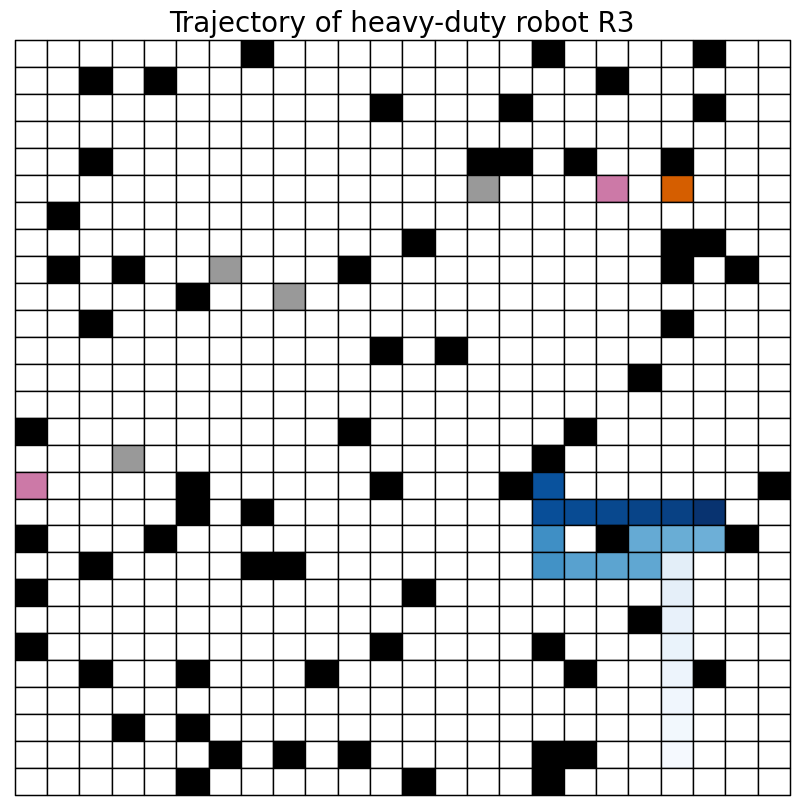

<Figure size 432x288 with 0 Axes>

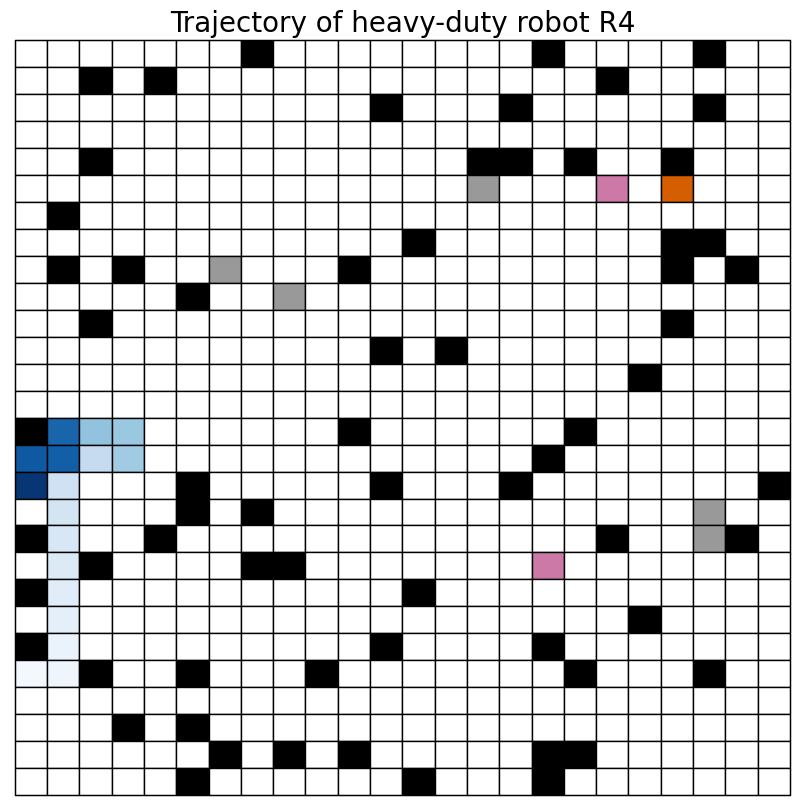

<Figure size 432x288 with 0 Axes>

In [11]:
"""
Get the data ready for plot and video
"""

independent_path_2d, record_working_region, record_task_left = \
    complete_path(world, v_light, independent_path_2d, states_work_region, record_working_region, record_task_left)

record_path_all = world.agents_light.path
for i in range(num_agent_heavy):
    record_path_all = np.concatenate((record_path_all, world.agents_heavy[i].path), axis=1)
    draw_path(map_obs_work, independent_path_2d[i], fig_folder, "Trajectory of heavy-duty robot R" + str(i + 1))

st = len(record_working_region[0])
for i in range(st, len(record_path_all)):
    for j in range(num_agent_heavy):
        record_working_region[j].append(record_working_region[j][-1])
        record_task_left[j].append(record_task_left[j][-1])

# animate_solution(map_obs_work, record_path_all, record_working_region, record_task_left, r_0, r_i, v_light,
#                  fig_folder, video=True)
